# Contemporary neuron simulators

Of course, it is *not* advised to implement the neuron models yourself for several reasons.
First, numerous people did this before you, so there is no need to reinvent the wheel.
Second, depending on your requirements, you might want much more sophisticated integration methods than Euler's.
Third, and probably most importantly, your code will likely be incredibly inefficient.

We will provide a brief review below, but will, for the sake of this course, teach one of the more modern spiking neuron simulators, Norse.

:::{note}
The [Open Neuromorphic](https://open-neuromorphic.org) community published a [comprehensive list of spiking neural network simulators](https://open-neuromorphic.org/neuromorphic-computing/software/) if you are curious about the simulator landscape.
:::

## Using machine learning accelerators

Simulating neurons is a classical SIMD problem: single instruction, multiple data.
Meaning, we have a single neuron model (instruction), but we want to apply it many, many times.
Graphical Processing Units (GPUs) are designed for exactly this, which is why modern neuron simulators rely heavily on GPUs to gain speed-ups of several orders of magnitude compared to CPUs.

Programming GPUs, however, is complicated.
It can be done, which is the case for the [SpikingJelly](https://open-neuromorphic.org/neuromorphic-computing/software/snn-frameworks/spikingjelly/) framework.
The downside is that it becomes prohibitively expensive to code a large number of neuron models, but SpikingJelly has been efficiently used in many publications for its efficiency.

Most contemporary simulators are built on modern machine learning accelerators like [PyTorch](https://pytorch.org) because they can compile the code down to more efficient representation.
In practice, that means most libraries can work with Python code, but get (most of) the efficiency of low-level GPU programming.
That is the case for the neuron simulator we will be using in this course, [Norse](https://github.com/norse/norse)


## Installing Norse

Before we start using Norse, let's install it:

In [1]:
!pip install norse -q

And import the necessary libraries

In [2]:
import matplotlib.pyplot as plt
import torch
import norse

# Working with Norse

For us, Norse is a tool to accelerate our own work within spiking neural networks (SNN).
This page serves to describe the fundamental ideas behind the Python code in Norse and
provide you with specific tools to become productive with SNN.

We will start by explaining some basic terminology, describe a *suggestion* to how Norse
can be approached, and finally give you some tasks and examples that will train you to
use Norse to solve specific problems.

## Terminology

### Events and action potentials

```{figure} book-fig-spikes.png
---
figclass: margin
name: fig_working_spikes
---
Illustration of discrete events, or *spikes*, from 10 neurons (y-axis) over 40 timesteps (x-axis) with events shown in white.
```

Neurons are well-known for their efficacy because they only react to sparse (rare) events called [spikes or action potentials](https://en.wikipedia.org/wiki/Action_potential).
In a spiking network, *less than* $2\%$ of the neurons are typically active at once.
In Norse, therefore, we mainly operate on **binary tensors** of 0's (no events) and 1's (spike!).
{numref}`fig_working_spikes` illustrates such a random sampled data with exactly $2\%$ activation.


### Neurons and neuron state
Neurons have parameters that determine their function. For example, they have a
certain membrane voltage that will lead the neuron to spike *if* the voltage is
above a threshold. Someone needs to keep track of that membrane voltage. If we 
wouldn't, the neuron membrane would never update, and we would never get any
spikes. In Norse, we refer to that as the **neuron state**.

In code, it looks like this:


In [3]:
cell = norse.torch.LIFBoxCell()
data = torch.ones(1)
spikes, state = cell(data)        # First run is done without any state
# ...
spikes, state = cell(data, state) # Now we pass in the previous state

States typically describe at least the neuron voltage (`v`) which illustrates the difference in "electric tension" in the neuron membrane.
The higher the value, the more tension and better chance to arrive at a spike.

Inspect the state below. What do you see? And what happens if you re-run the cell with the new state?

In [4]:
state

LIFBoxFeedForwardState(v=tensor([0.1900], grad_fn=<AddBackward0>))

### Neuron dynamics and time

Norse solves two of the hardest parts about running neuron simulations: neural equations and temporal dynamics.
We provide a long list of neuron model implementations, as listed [in our documentation](https://norse.github.io/norse/generated/norse.torch.html#neuron-models) that is free to plug'n'play.

Aligning with [PyTorch's API](https://pytorch.org/docs/stable/nn.html), we distinguish between simple neuron models that take one input timestep and returns one output timestep.
Those models are effectively recurrent neural networks (RNNs) because we have to feed in the previous state (e.g. voltage) into the next timestep.
If we didn't, the neuron would not know its current voltage potential.

There are two ways you can achieve that.
By looping or by using the Norse built-ins.

## Task 1: Evolve a neuron in time

Create a `LIFBoxCell` from Norse and use the time-series data below in a loop to produce spikes.

In [5]:
data = torch.ones(100)

# Loop here
# ...

Norse also has a `Lift` module, which works by "lifting" the neuron into the time domain.
Effectively, the `Lift` module simply wraps the neuron in a `for`-loop so you don't have to:

In [6]:
data = torch.ones(100, 3) * torch.tensor([1, 2, 3])
cell = norse.torch.Lift(norse.torch.LIFBoxCell())
out, state = cell(data)

# Plot the output:
# plt.plot(out)

Oh-oh! What happened above? Can you figure out how to plot it?

## PyTorch as optimization framework

PyTorch is designed as an optimization framework that heavily relies on backpropagation. 
In fact, all computational graphs in PyTorch are being traced and tracked so you can easily calculate gradients at a later point in time.
We will discuss this more in-depth in the coming weeks.
For now, just `detach` the gradients or use the Norse plotting utils:

<Axes: >

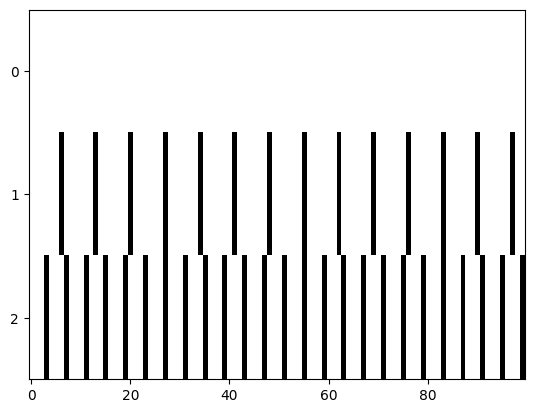

In [7]:
norse.torch.plot_spikes_2d(out)

## Task 2: Change the time constant of the `LIFBoxCell`

Above, we used the default behaviour of the `LIFBoxCell`.
As you know, the time constant is an important factor, and we can parameterize that using a `LIFBoxParameter` class.
It contains a `tau_mem_inv` which is the inverse time constant you were using in the previous notebook.

Use the parameter object below to modify the time constant and see what happens with the behaviour of the `LIFBoxCell`.
Can you set it so that it spikes more often? 

In [8]:
p = norse.torch.LIFBoxParameters(tau_mem_inv=200)
cell = norse.torch.Lift(norse.torch.LIFBoxCell(p))

# What happens when you apply the same input data as before?

## Currents and box integrations

So far, we have been directly integrating current into our membrane.
We can call this "box integration" because the integration is happening stepwise, similar to a box:

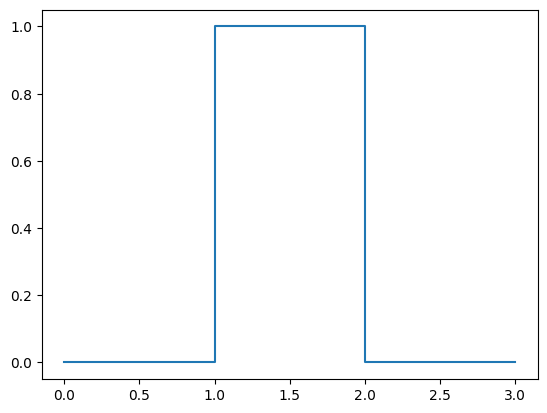

In [9]:
plt.plot([0, 1, 1, 2, 2, 3], [0, 0, 1, 1, 0, 0])

But that's not how physics works.
Current describes the rate of flow of electrons, and voltage is the difference in charge between two points.
In real, physical neurons, the current will slowly build up and *charge* the membrane over time.
So an integration with a discrete signal will look like this:

![](li.gif)

That is, we actually have *two* time constants!
One for charge (or the neuron synapses) $\tau_{\text{syn}}$ and one for the membrane voltage $\tau_{\text{mem}}$.

In Norse, we distinguish between two types of models `LIBoxCell` which is a leaky integrator with box integration and `LICell` which is a leaky integrator with a current term.

## Task 3: Study `LIBoxCell` and `LICell`

Using a simple sinusiodal input current, study the different integrations of the `LIBoxCell` and `LICell`.

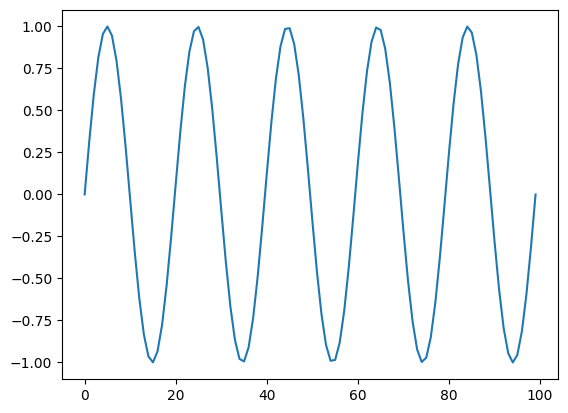

In [10]:
input_current = torch.linspace(0, torch.pi * 10, 100).sin()
plt.plot(input_current)

In [12]:
p = norse.torch.LIFBoxParameters(tau_mem_inv=200)
box = norse.torch.LIBoxCell()
# What happens when you use the sinusoidal input from above?

In [11]:
p = norse.torch.LIParameters(tau_mem_inv = 100, tau_syn_inv = 100)
cell = norse.torch.LICell(p)
# What happens when you use the sinusoidal input from above?

## Task 4: Redraw the time surface with Norse

Using Norse cells, redraw the time surface plot from before.

In [15]:
data = torch.load("sound_data.dat")
surface = ...

# Plot the output
# plt.imshow(surface)

## Norse workflow

Norse is meant to be used as a library. Specifically, that means taking parts of it and
remixing to fit the needs of a specific task. 
We have tried to provide useful, documented, and correct features from the spiking neural network domain, such
that they become simple to work with.

The two main differences from classical artificial neural networks is 1) the state variables containing the neuron parameters
and 2) the temporal dimension means integrating the neuron over time. 
Apart from that, Norse works like you would expect any PyTorch module to work.

When working with Norse, we recommend that you consider two things

1. What neuron models will you need?
2. What learning algorithms and/or plasticity models will you need?


### Deciding on neuron models

The choice of neuron model depends on the task. Should the model be biologically plausible? Computationally efficient? ...
Two popular choices of models are the [leaky integrate-and-fire neuron model](https://norse.github.io/norse/norse.torch.html#leaky-integrate-and-fire-lif), which will provide spiking output of either `0`s or `1`s. Another model is the [leaky integrator](https://norse.github.io/norse/norse.torch.html#leaky-integrator), which will provide a voltage scalar output.
Many more neuron models exist and can be found in our documentation: https://norse.github.io/norse/norse.torch.html#neuron-models

### Deciding on learning/plasiticy models

Optimization can be done using PyTorch's gradient-based optimizations, as seen in the [MNIST task](https://github.com/norse/norse/blob/master/norse/task/mnist.py#L100). We have implemented [SuperSpike](https://arxiv.org/abs/1705.11146v2) and many other [surrogate gradient methods](https://arxiv.org/abs/1901.09948) that lets you seamlessly integrate with Norse. The surrogate gradient methods are documented here: https://norse.github.io/norse/norse.torch.functional.html#threshold-functions

If you require biological/local learning, we support plasticity via [STDP](https://norse.github.io/norse/generated/norse.torch.functional.stdp.html#module-norse.torch.functional.stdp) and [Tsodyks-Markram](https://norse.github.io/norse/generated/norse.torch.functional.tsodyks_makram.html#module-norse.torch.functional.tsodyks_makram) models.

## Examples of deep learning problems in Norse

Norse can be applied immediately for both fundamental research and deep learning problems.

To **port existing deep learning problems**, we can simply 1) replicate ANN architecture, 2) lift the signal in time (to allow the neurons time to react to the input signal), and 3) replace the ANN activation functions with SNN activation functions.

We have several examples of that in our [tasks section](https://norse.github.io/norse/pages/tasks.html), and [MNIST](https://github.com/norse/norse/blob/master/norse/task/mnist.py) is one of them; here we 1) build a convolutional network, 2) convert the MNIST dataset into sparse discrete events and 3) solve the task with LIF models, achieving >90% accuracy.

We can also **replicate experiments from the literature**, as shown in the [memory task](https://github.com/norse/norse/blob/master/norse/task/memory.py) example. Here we use [adaptive long short-term spiking neural networks](https://github.com/IGITUGraz/LSNN-official) to solve temporal memory problems.